In [1]:
!pip install Sastrawi wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
from nltk import ngrams
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np

Membaca data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Membaca file dengan encoding latin-1
df = pd.read_csv('/content/drive/MyDrive/Data_Tiktok/scrapped_tiktok_reviews.csv', sep=';', encoding='latin-1')

# Menampilkan beberapa baris pertama
print(df.head())


                               reviewId         userName  \
0  b701c159-af5a-424e-8054-5ebbb15f8d29  Pengguna Google   
1  1964d538-222a-490d-833c-262f18a61c55  Pengguna Google   
2  ee3d3a41-8071-4223-b286-c8b407e20fba  Pengguna Google   
3  a5d9432f-4f7f-4d83-b6f4-118de6a536ad  Pengguna Google   
4  1521c24e-e5eb-4b27-ae77-7ee75b1b6f27  Pengguna Google   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0  Tiktok makin hari makan buruk kayak anjeng ......      1              0   
1  Hbs di update mlh eror susah di buka hnya berp...      1              0   
2                                          Bagus aja      3         

menghapus baris dengan kolom 'content' kosong untuk membersihkan data


In [5]:
df.dropna(subset=['content'], inplace=True)
print(df)

                                  reviewId               userName  \
0     b701c159-af5a-424e-8054-5ebbb15f8d29        Pengguna Google   
1     1964d538-222a-490d-833c-262f18a61c55        Pengguna Google   
2     ee3d3a41-8071-4223-b286-c8b407e20fba        Pengguna Google   
3     a5d9432f-4f7f-4d83-b6f4-118de6a536ad        Pengguna Google   
4     1521c24e-e5eb-4b27-ae77-7ee75b1b6f27        Pengguna Google   
...                                    ...                    ...   
9995  68850f25-8fd8-4d03-a34b-74bbc605b276              ania Nana   
9996  d021ad02-4c42-4548-b295-f5992b4cd855             Eko Cacing   
9997  c7d2e2d8-4be2-4b7b-a6ab-ced74ea67722            Ina Djaylim   
9998  9c4b106e-e09a-4608-ab99-4d2cc42151ed          Agus Friyanto   
9999  1815586f-b6e5-41f4-a9e1-4a3730bc7447  Malaikat Muda (Peonk)   

                                              userImage  \
0     https://play-lh.googleusercontent.com/EGemoI2N...   
1     https://play-lh.googleusercontent.com/EGemoI2N.

Menghapus baris dengan konten kosong atau konten tidak jelas

In [6]:
# Menghapus baris yang memiliki konten kosong atau hanya berisi spasi
df = df[df['content'].str.strip().astype(bool)]
# Menghapus baris yang memiliki panjang konten kurang dari 3 karakter
df = df[df['content'].str.len() >= 3]
# Menampilkan DataFrame setelah filter
print(df)


                                  reviewId               userName  \
0     b701c159-af5a-424e-8054-5ebbb15f8d29        Pengguna Google   
1     1964d538-222a-490d-833c-262f18a61c55        Pengguna Google   
2     ee3d3a41-8071-4223-b286-c8b407e20fba        Pengguna Google   
3     a5d9432f-4f7f-4d83-b6f4-118de6a536ad        Pengguna Google   
5     6ae62271-e81f-4b54-b53f-ec1badb0c6e3        Pengguna Google   
...                                    ...                    ...   
9995  68850f25-8fd8-4d03-a34b-74bbc605b276              ania Nana   
9996  d021ad02-4c42-4548-b295-f5992b4cd855             Eko Cacing   
9997  c7d2e2d8-4be2-4b7b-a6ab-ced74ea67722            Ina Djaylim   
9998  9c4b106e-e09a-4608-ab99-4d2cc42151ed          Agus Friyanto   
9999  1815586f-b6e5-41f4-a9e1-4a3730bc7447  Malaikat Muda (Peonk)   

                                              userImage  \
0     https://play-lh.googleusercontent.com/EGemoI2N...   
1     https://play-lh.googleusercontent.com/EGemoI2N.

Menghapus kolom yang tidak diperlukan dalam proses analisis sentimen

In [7]:
# Daftar kolom yang akan dihapus
columns_to_drop = ['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'replyContent', 'repliedAt', 'appVersion','score', 'at']
# Mengecek kolom yang ada dalam DataFrame dan akan dihapus
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
# Menampilkan kolom yang akan dihapus
print("Kolom yang akan dihapus:", existing_columns_to_drop)
# Menghapus kolom yang ada dalam DataFrame
df = df.drop(columns=existing_columns_to_drop)
# Menampilkan DataFrame setelah kolom dihapus
print(df)


Kolom yang akan dihapus: ['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'replyContent', 'repliedAt', 'appVersion', 'score', 'at']
                                                content
0     Tiktok makin hari makan buruk kayak anjeng ......
1     Hbs di update mlh eror susah di buka hnya berp...
2                                             Bagus aja
3     Makin ke sini apk tik tok nya suka mental send...
5                                       ya sangat bagus
...                                                 ...
9995                                       Sangat bagus
9996                    terkadang mental keluar sendiri
9997  Sukses dan Lancar Terus Gopay. Gojek is The Be...
9998  Verifikasi susah lama sampai sekarang belom te...
9999                    Lag parah min, macet hp poco f1

[9710 rows x 1 columns]


Kamus Normalisasi

In [8]:
# Path ke file normalisasi
normalization_dict_path = '/content/drive/MyDrive/Data_Tiktok/normalization_dict.csv'

# Membaca file CSV normalisasi
normalization_df = pd.read_csv(normalization_dict_path)

# Memastikan kolom yang diperlukan ada
if 'informal' in normalization_df.columns and 'formal' in normalization_df.columns:
    # Membuat kamus dari kolom 'informal' dan 'formal'
    normalization_dict = pd.Series(normalization_df.formal.values, index=normalization_df.informal).to_dict()
    print("Kamus normalisasi berhasil dibuat:")
    print(normalization_dict)
else:
    raise ValueError("File normalization_dict.csv harus memiliki kolom 'informal' dan 'formal'.")

# Menampilkan beberapa baris pertama dari dataframe untuk memverifikasi format
print("Tampilan beberapa baris pertama dari dataframe:")
print(normalization_df.head())

Kamus normalisasi berhasil dibuat:
{'bisa-bisa': 'dapat-dapat', 'bisa jadi': 'dapat menjadi', 'dah': 'sudah', 'sampe': 'sampai', 'gila': 'sangat', 'nanti': 'nanti', 'pasti': 'pasti', 'wkwk': 'tertawa', 'kapan': 'kapan', 'yaudah': 'ya sudah', 'ngajarin': 'mengajari', 'ngebosenin': 'membosankan', 'ngadain': 'mengadakan', 'ngedapetin': 'mendapatkan', 'gakusah': 'tidak usah', 'ngebut': 'mempercepat', 'ya': 'iya', 'kok': 'mengapa', 'bisa apa': 'dapat apa', 'nggak ngaruh': 'tidak berpengaruh', 'emang': 'm memang', 'ya gitu deh': 'begitulah', 'gak ada': 'tidak ada', 'sok': 'berlagak', 'nggak usah': 'tidak usah', 'bisa dibilang': 'dapat dikatakan', 'nggak ngerti': 'tidak mengerti', 'mantap': 'bagus', 'oke': 'baik', 'keren': 'hebat', 'bagus': 'baik', 'seru': 'menyenangkan', 'lumayan': 'cukup', 'gak': 'tidak', 'bete': 'jenuh', 'sngt': 'sangat', 'bgttt': 'banget', 'skli': 'sekali', 'dpt': 'dapat', 'nyaman': 'nyaman', 'bisalah': 'dapatlah', 'yg': 'yang', 'karna': 'karena', 'hp': 'ponsel', 'ok': 'o

 normalisasi teks menggunakan kamus

In [9]:
def normalize_text(text, norm_dict):
    for word, correct_word in norm_dict.items():
        text = re.sub(r'\b' + re.escape(word) + r'\b', correct_word, text)
    return text

Fungsi untuk membersihkan teks

In [10]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Menghapus karakter yang bukan huruf
    text = text.lower()  # Mengubah teks ke huruf kecil
    text = normalize_text(text, normalization_dict)  # Normalisasi teks
    return text

    # Pembersihan teks dan normalisasi ke kolom 'content'
df['content'] = df['content'].apply(clean_text)

df = df[df['content'].str.contains('[a-zA-Z]')]


Menggunakan stopwords dari sastrawi untuk bahasa Indonesia


In [11]:
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

Fungsi untuk menghapus stopwords


In [12]:
def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word not in stopwords])


Fungsi penghapusan stopwords ke kolom 'content'


In [13]:
df['content'] = df['content'].apply(remove_stopwords)

Menampilkan DataFrame hasil preprocessing


In [14]:
print(df.head())

                                             content
0  tiktok makin hari makan buruk kayak anjeng suk...
1  hbs update mlh eror susah buka hnya berputar l...
2                                               baik
3  makin sini aplikasi tik tok nya suka mental se...
5                                    iya sangat baik


In [15]:
df.to_csv('PreProcessing_DataUlasanTiktok_Kelompok8.csv', index=False)

In [16]:

# Kamus sentimen
sentiment_dict = {
     # Negatif Sentiment
    "buruk": "negatif",
    "tidak": "negatif",
    "lemot": "negatif",
    "susah": "negatif",
    "jelek": "negatif",
    "tidak sesuai harapan": "negatif",
    "tidak sesuai harapannya": "negatif",
    "error": "negatif",
    "masalah": "negatif",
    "mental": "negatif",
    "anjing": "negatif",
    "menyebalkan": "negatif",
    "kecewa": "negatif",
    "lemot sekali": "negatif",
    "parah": "negatif",
    "bug": "negatif",
    "ngelag": "negatif",
    "hapus": "negatif",
    "lambat": "negatif",
    "tidak berfungsi": "negatif",
    "mengganggu": "negatif",
    "tidak puas": "negatif",
     "kesel" : "negatif",
     "kurang" : "negatif",
     "tidak sesuai" : "negatif",

    # Positif Sentiment
    "baik": "positif",
    "bagus": "positif",
    "menarik": "positif",
    "mantap": "positif",
    "sangat": "positif",
    "suka": "positif",
     "menyukai" : "positif",
    "terbaik": "positif",
    "terbaiknya": "positif",
    "puas": "positif",
    "hebat": "positif",
    "menghibur": "positif",
    "senang": "positif",
    "keren": "positif",
    "mengesankan": "positif",
    "lancar": "positif",
    "bagus sekali": "positif",
    "menyenangkan": "positif",
    "rekomendasi": "positif",
    "memuaskan": "positif",
    "cinta" : "positif",
     "canggih " : "positif",
     "luar biasa" : "positif",
     "membantu" : "positif",
     "oke" : "positif"
}

# Fungsi untuk normalisasi teks
def normalize_text(text):
    text = text.lower()  # Case-folding
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Menghapus karakter non-alphabet
    return text

# Fungsi untuk menentukan sentimen
def get_sentiment(text, sentiment_dict):
    words = text.split()
    # Prioritaskan sentimen negatif
    for word in words:
        if word in sentiment_dict and sentiment_dict[word] == "negatif":
            return "negatif"
    # Jika tidak ada kata negatif, cari kata positif
    for word in words:
        if word in sentiment_dict and sentiment_dict[word] == "positif":
            return "positif"
    return "negatif"  # Default: Jika tidak ada sentimen, anggap negatif


# Proses sentimen
df['normalized_content'] = df['content'].apply(lambda x: normalize_text(x))
df['sentiment'] = df['normalized_content'].apply(lambda x: get_sentiment(x, sentiment_dict))

# Urutkan data: positif di atas, negatif di bawah
df = df.sort_values(by='sentiment', ascending=False, key=lambda x: x.map({"positif": 1, "negatif": 0}))

# Simpan hasil ke file CSV
output_path = 'sentiment_analysis_result.csv'
df.to_csv(output_path, index=False)

# Tampilkan hasil
print(df)

# Unduh file (jika menggunakan Google Colab atau Jupyter Notebook dengan pengunduhan)
try:
    from google.colab import files
    files.download(output_path)
except ImportError:
    print(f"File saved to {output_path}")


                                content                 normalized_content  \
8202                      aplikasi baik                      aplikasi baik   
8204            apikasi nya baik sangat            apikasi nya baik sangat   
3205       suka sangat loh cobain dehoo       suka sangat loh cobain dehoo   
3204                  sangat baik cocok                  sangat baik cocok   
5450                       baik boskuuu                       baik boskuuu   
...                                 ...                                ...   
4251                              heppy                              heppy   
4249              susah aktifin tt shop              susah aktifin tt shop   
4248                            mantaap                            mantaap   
4245                         bisah buka                         bisah buka   
9999  lag parah min macet ponsel poco f  lag parah min macet ponsel poco f   

     sentiment  
8202   positif  
8204   positif  
3205   posit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualisasi Countplot

<ipython-input-17-1edd49ee5243>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', order=sentiment_order, palette='pastel')


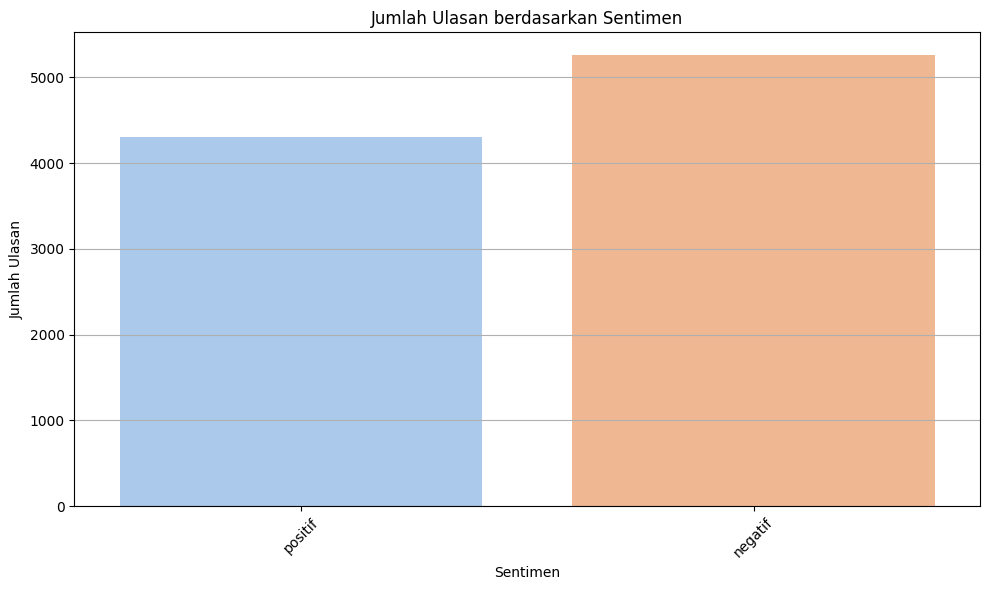

In [17]:
file_path = '/content/sentiment_analysis_result.csv'  # Ganti path sesuai lokasi file
df = pd.read_csv(file_path)

# Menentukan urutan sentimen yang ingin ditampilkan (Positif, Negatif)
sentiment_order = ['positif', 'negatif']  # Sesuaikan dengan data, pastikan sesuai dengan nilai di kolom 'sentiment'

# Membuat plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', order=sentiment_order, palette='pastel')

# Menambahkan judul dan label
plt.title('Jumlah Ulasan berdasarkan Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')

# Menambahkan rotasi untuk label x-axis jika perlu
plt.xticks(rotation=45)

# Menambahkan grid pada sumbu y
plt.grid(axis='y')

# Mengatur layout agar tidak terpotong
plt.tight_layout()

# Menampilkan plot
plt.show()

Visualisasi Word Cloud

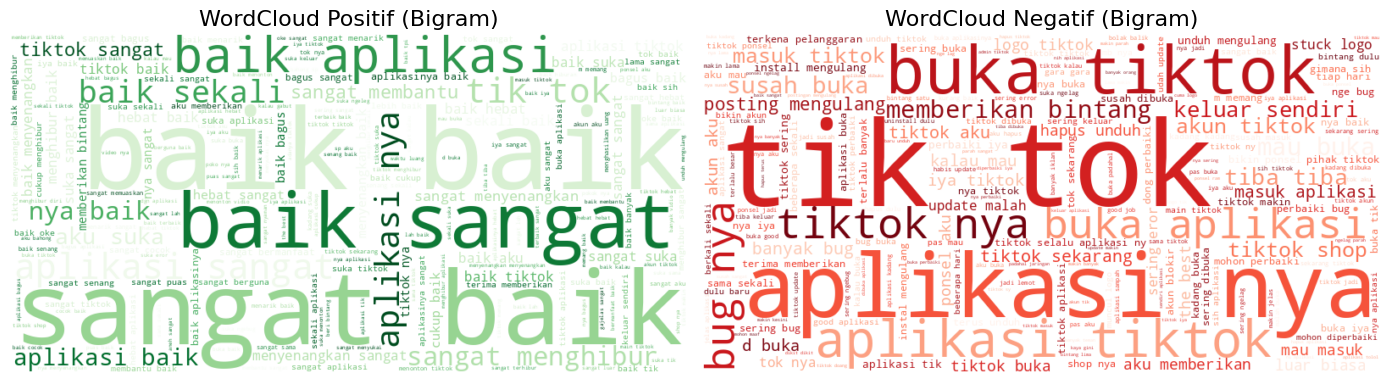

In [18]:
file_path = '/content/sentiment_analysis_result.csv'  # Ganti path sesuai lokasi file Anda
df = pd.read_csv(file_path)

# Fungsi untuk membuat bigram
def generate_bigrams(text):
    # Pisahkan teks menjadi kata-kata
    words = text.split()
    # Buat bigram dari kata-kata
    bigrams = ngrams(words, 2)
    return [' '.join(bigram) for bigram in bigrams]

# Pisahkan ulasan berdasarkan sentimen positif dan negatif
positive_reviews = ' '.join(df[df['sentiment'] == 'positif']['content'].dropna())
negative_reviews = ' '.join(df[df['sentiment'] == 'negatif']['content'].dropna())

# Menghasilkan bigram untuk sentimen positif dan negatif
positive_bigrams = generate_bigrams(positive_reviews)
negative_bigrams = generate_bigrams(negative_reviews)

# Menghitung frekuensi bigram
positive_bigram_freq = Counter(positive_bigrams)
negative_bigram_freq = Counter(negative_bigrams)

# Membuat WordCloud untuk sentimen positif berdasarkan bigram
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate_from_frequencies(positive_bigram_freq)

# Membuat WordCloud untuk sentimen negatif berdasarkan bigram
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(negative_bigram_freq)

# Menampilkan kedua WordCloud
plt.figure(figsize=(14, 7))

# WordCloud Positif
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Positif (Bigram)', fontsize=16)

# WordCloud Negatif
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Negatif (Bigram)', fontsize=16)

# Menampilkan plot
plt.tight_layout()
plt.show()

K-Means

Kolom dalam dataset: Index(['content', 'normalized_content', 'sentiment'], dtype='object')
Ada 5 nilai NaN dalam kolom 'normalized_content'. Menghapus atau mengganti nilai tersebut.
Shape of TF-IDF Matrix: (9572, 7870)


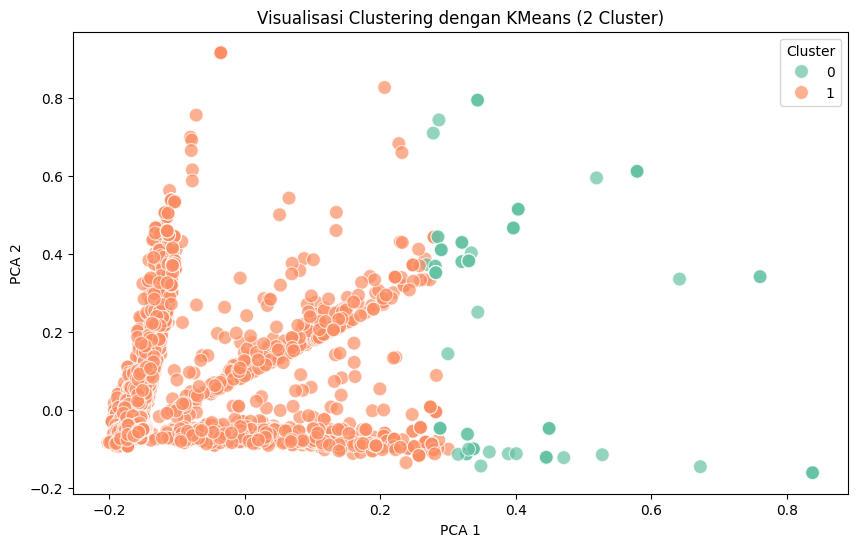

Hasil clustering telah disimpan ke 'hasil_clustering_kmeans.csv'


In [19]:
file_path = '/content/sentiment_analysis_result.csv'  # Ganti path sesuai lokasi file Anda
df = pd.read_csv(file_path)

# Menampilkan kolom yang tersedia untuk memastikan kolom teks yang benar
print("Kolom dalam dataset:", df.columns)

# Gunakan kolom teks yang sesuai
text_column = 'normalized_content'  # Pilih 'content' atau 'normalized_content'

# Mengatasi nilai NaN dalam kolom teks
if df[text_column].isnull().any():
    print(f"Ada {df[text_column].isnull().sum()} nilai NaN dalam kolom '{text_column}'. Menghapus atau mengganti nilai tersebut.")
    df[text_column] = df[text_column].fillna("")  # Ganti NaN dengan string kosong

# 1. Menggunakan TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df[text_column])

# Menampilkan shape TF-IDF Matrix
print(f"Shape of TF-IDF Matrix: {X.shape}")

# 2. Clustering dengan KMeans
kmeans = KMeans(n_clusters=2, random_state=42)  # Ubah jumlah cluster menjadi 2
df['kmeans_cluster'] = kmeans.fit_predict(X)

# 3. Visualisasi hasil clustering dengan PCA (mengurangi dimensi menjadi 2D)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())
df['pca1'] = principal_components[:, 0]
df['pca2'] = principal_components[:, 1]

# Plot hasil clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='kmeans_cluster', data=df, palette='Set2', s=100, alpha=0.7)
plt.title('Visualisasi Clustering dengan KMeans (2 Cluster)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

# 4. Menyimpan hasil clustering ke dalam file CSV
df.to_csv('hasil_clustering_kmeans.csv', index=False)

print("Hasil clustering telah disimpan ke 'hasil_clustering_kmeans.csv'")

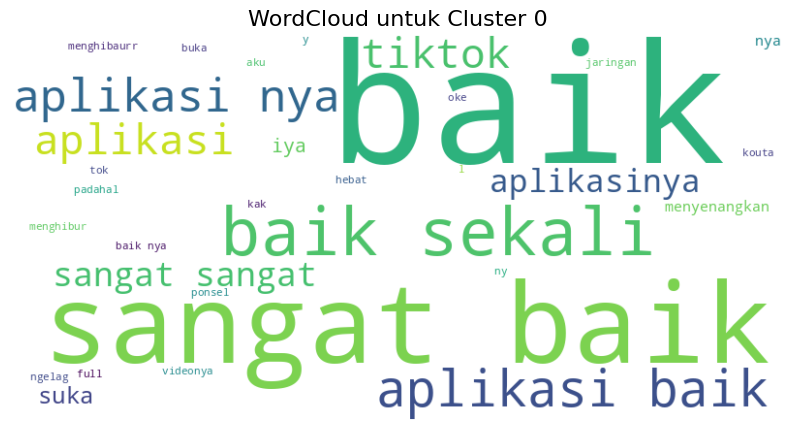

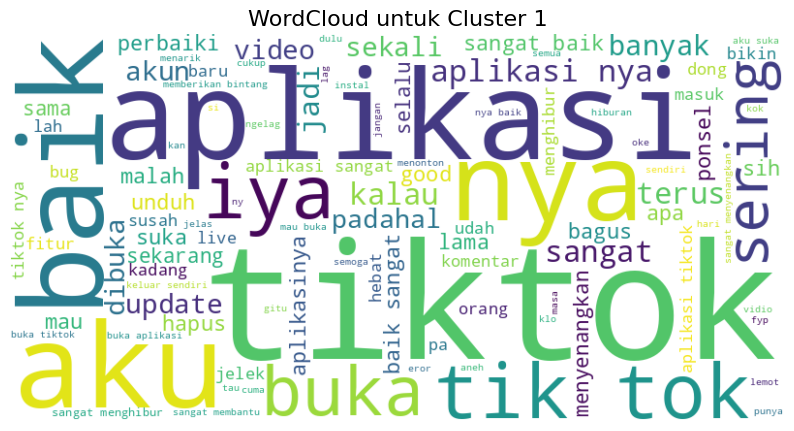

WordCloud telah dibuat untuk setiap cluster, dan hasil clustering telah disimpan ke 'hasil_clustering_kmeans_2_clusters.csv'


In [20]:
clusters = df['kmeans_cluster'].unique()  # Ambil daftar cluster
for cluster in clusters:
    # Filter data untuk cluster tertentu
    cluster_text = " ".join(df[df['kmeans_cluster'] == cluster]['normalized_content'])

    # Menghasilkan WordCloud berdasarkan teks cluster
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(cluster_text)

    # Tampilkan WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud untuk Cluster {cluster}', fontsize=16)
    plt.show()

# 7. Menyimpan hasil clustering ke dalam file CSV
df.to_csv('hasil_clustering_kmeans_2_clusters.csv', index=False)

print("WordCloud telah dibuat untuk setiap cluster, dan hasil clustering telah disimpan ke 'hasil_clustering_kmeans_2_clusters.csv'")